# Publication-Quality Figures for JPP

## Setup

In [39]:
# %% Imports
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import scipy.interpolate
import scipy.special

import pickle
import gudhi
import gudhi.representations

from adios2 import FileReader
from netCDF4 import Dataset

from tqdm.notebook import tqdm

import pickle

from c1lgkt.fields.equilibrium import Equilibrium
from c1lgkt.fields.field_handlers import GaussHermiteFieldHandler, XgcZonalFieldHandler, XgcFieldHandler
from c1lgkt.fields.geometry_handlers import XgcGeomHandler
from c1lgkt.fields.field_analysis import upsample_fft_dpot
from c1lgkt.fields.utility import refine_max_position

import c1lgkt.particles.particle_motion as particle_motion
import c1lgkt.particles.particle_tools as particle_tools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# %% matplotlib settings
font = {'size'   : 9 }

linescale = 0.6
mpl.rc('axes', unicode_minus=False, linewidth=linescale)
mpl.rc('lines', markersize=6.0*linescale, linewidth=1.5*linescale)

tick_major = {'size': 3.5*linescale, 'width': 0.8*linescale}
tick_minor = {'size': 2.0*linescale, 'width': 0.6*linescale}

mpl.rc('xtick.major', **tick_major)
mpl.rc('ytick.major', **tick_major)
mpl.rc('xtick.minor', **tick_minor)
mpl.rc('ytick.minor', **tick_minor)
mpl.rc('xtick', direction='in')
mpl.rc('ytick', direction='in')

mpl.rc('font', **font)

In [3]:
# %% Load universally-used data

drive_letter = 'D:'

## Data files
eq = Equilibrium.from_eqdfile(drive_letter + R'\Documents\IFS\hmode_jet\D3D141451.eqd')
xgcdata = Dataset(drive_letter + R'\Documents\Globus\XGC1.nc')

geom_files = {
    'ele_filename': drive_letter + R'\Documents\IFS\hmode_jet\Seo.eqd.ele',
    'fdmat_filename': drive_letter + R'\Documents\IFS\hmode_jet\fdmat.pkl',
    'min_e_filename': drive_letter + R'\Documents\IFS\hmode_jet\min_E_mat.pkl'
}
geom = XgcGeomHandler(eq, xgcdata, theta0_mode='max_drive', **geom_files)

## Compute zonal flows
zpot = xgcdata['pot00'][:,:]
zpot_psi = xgcdata['psi00'][:]
t = xgcdata['t'][:]

zfield = np.gradient(zpot, axis=1) / np.gradient(zpot_psi)[np.newaxis,:]
dzfield = np.gradient(zfield, axis=1) / np.gradient(zpot_psi)[np.newaxis,:]

## Phase velocity data
ph_data = np.load('./outputs/phase_vel.npz')
u_lstsq = ph_data['u_lstsq']
phimax = ph_data['phimax']

## Summary statistics
summary_data = np.load('./outputs/summary_data.npz')

In [37]:
# %% Compute toroidal flux for geometric terms

## Get an interpolation function for the unnormalized toroidal flux
tor_flux = geom.interp_q.antiderivative()

# Toroidal flux at the x-point
torx = tor_flux(eq.psix)

def interp_rho_tor(psi):
    """
    Computes the normalized rho_tor for the unnormalized poloidal flux psi.
    """
    return np.sqrt(tor_flux(psi)/torx)

def rho_tor_gradient(psi, f, axis=None):
    """
    Computes df/drho_tor in normalized toroidal flux coordinates. Use amin to get unnormalized toridal flux coordinates.
    """
    # Normalized toroidal flux coordinate
    rho_tor = np.sqrt(tor_flux(psi) / torx)

    # Conversion factor, df/drho_tor drho_tor/dpsi = df/dpsi
    rho_deriv = (eq.psix / torx) * 2 * geom.interp_q(psi) / (2 * rho_tor)

    # Gradient of f in normalized toroidal flux coordinates
    df = np.gradient(f, axis=axis) / (np.gradient(psi) * rho_deriv)

    return df

dzfield_rtor = rho_tor_gradient(zpot_psi, zfield, axis=1)

amin = (np.max(eq.lcfsrz[:,0]) - np.min(eq.lcfsrz[:,0]))/2

#plt.figure()
#plt.plot(zpot_psi/eq.psix, dzfield_rtor[400,:]*1e-3, label='Zonal flow')
#plt.ylim(-250, 250)

C:\Users\maple\AppData\Local\Temp\ipykernel_19144\3574296340.py:20: RuntimeWarning: invalid value encountered in sqrt
  rho_tor = np.sqrt(tor_flux(psi) / torx)


## Hovmoller Diagrams

### Loading and Setup

In [7]:
# %% Load profile data

# File for one-dimensional profile data
oned_file = drive_letter + R"\Documents\Globus\XGC1_HD3D_elec_rgn1_run4\xgc.oneddiag.bp"

with FileReader(oned_file) as s:
    ## inspect variables
    #vars = s.available_variables()
    #for name, info in vars.items():
    #    print("variable_name: " + name, end=" ")
    #    for key, value in info.items():
    #        print("\t" + key + ": " + value, end=" ")
    #    print()
    #print()

    ## Load electron and ion gyrocenter profiles
    e_gc_den = s.read('e_gc_density_df_1d', step_selection=[0, 500]).reshape((500,-1))
    i_gc_den = s.read('i_gc_density_df_1d', step_selection=[0, 500]).reshape((500,-1))
    i_T_perp = s.read('i_perp_temperature_df_1d', step_selection=[0, 500]).reshape((500,-1))
    e_T_perp = s.read('e_perp_temperature_df_1d', step_selection=[0, 500]).reshape((500,-1))
    i_en_flux = s.read('i_radial_en_flux_df_1d', step_selection=[0, 500]).reshape((500,-1))
    i_gc_flux = s.read('i_radial_flux_1d', step_selection=[0, 500]).reshape((500,-1))

    i_parallel_flow = s.read('i_parallel_flow_df_1d', step_selection=[0, 500]).reshape((500,-1))
    i_toroidal_flow = s.read('i_gc_toroidal_flow_df_1d', step_selection=[0, 500]).reshape((500,-1))

    ## Load flux grid
    psi_mks = s.read('psi_mks')

# File for mesh data, which contains the reference profiles
mesh_file = drive_letter + R"\Documents\Globus\XGC1_HD3D_elec_rgn1_run4\xgc.f0.mesh.bp"

with FileReader(mesh_file) as s:
    f0_T_ev = s.read('f0_T_ev')
    f0_den = s.read('f0_den')

    # Extract the reference profiles from the mesh normalizations
    e_T_ev_0 = f0_T_ev[0,geom.breaks_surf[:-1]]
    i_T_ev_0 = f0_T_ev[1,geom.breaks_surf[:-1]]
    den_0 = f0_den[0,geom.breaks_surf[:-1]]

## Compute the shearless curve for each time step
psi_shearless = np.empty(len(t))

psi_inds = np.searchsorted(zpot_psi/eq.psix, (0.77,0.82))

for tind in range(len(t)):
    psi_shearless[tind], _ = refine_max_position(zpot_psi[psi_inds[0]:psi_inds[1]], -zfield[tind,psi_inds[0]:psi_inds[1]])

In [69]:
# %% Define plots

#cax_inset = [0.01, 0.3, 0.3, 0.15]
cb_props = {'orientation': 'vertical'}
text_bbox = {'facecolor': 'white',
             'alpha': 0.8,
             'boxstyle': 'round'}
text_props = {'x': 0.012, 'y': 0.03,
              'size': 9,
              'va': 'bottom', 'ha': 'left',
              'bbox': text_bbox}
psi_lim_ax = (0.6,0.95)
psi_lim_data = (0.625,0.95)
t_lim = (t[200]*1e3, t[-1]*1e3)

def find_vlim(t, psi, field):
    """
    Finds the vmin and vmax for a given field inside the limits of t and psi
    """
    t_inds = np.searchsorted(t, t_lim)
    psi_inds = np.searchsorted(psi, psi_lim_data)
    field_masked = field[psi_inds[0]:psi_inds[1], t_inds[0]:t_inds[1]]
    vmin = np.nanmin(field_masked)
    vmax = np.nanmax(field_masked)
    return vmin, vmax

def plot_hovmoller_shearless_contours(ax: mpl.axes.Axes):
    ax.plot(t*1e3, psi_shearless/eq.psix, color='tab:gray')

    #ax.axhline(0.8, color='tab:gray', linestyle='--')

    #cont = ax.contour(t*1e3, zpot_psi/eq.psix, -dzfield.T*1e-3,
    #                  levels=[0], colors='tab:gray', alpha=0.5)
    
    pass

def plot_hovmoller(t, psi, field: np.ndarray, cmap, ax: mpl.axes.Axes, cax: mpl.axes.Axes, label: str, cax_label: str, vmin = None, vmax = None):
    ## Get limits for plotting
    vmin_data, vmax_data = find_vlim(t, psi, field)
    vmin = vmin_data if vmin is None else vmin
    vmax = vmax_data if vmax is None else vmax

    ## Adjust limits and set labels
    ax.set_ylim(psi_lim_ax)
    ax.set_xlim(t_lim)
    ax.set_ylabel(R'$\psi_n$')
    ax.xaxis.set_tick_params(labelbottom=False)

    ## Plot the field
    pc = ax.pcolormesh(t, psi, field, cmap=cmap, vmin=vmin, vmax=vmax, rasterized=True)
    
    ## Decorate with the shearless contours
    plot_hovmoller_shearless_contours(ax)

    ## Label the plots
    if label != '':
        ax.text(s=label, transform=ax.transAxes, **text_props)

    if cax is not None:
        # Determine which ends of the colorbar to extend
        if vmin > vmin_data:
            if vmax < vmax_data:
                extend = 'both'
            else:
                extend = 'min'
        else:
            if vmax < vmax_data:
                extend = 'max'
            else:
                extend = 'neither'

        plt.colorbar(pc, cax=cax, label=cax_label, extend=extend, **cb_props)


### Figures for Slides

C:\Users\maple\AppData\Local\Temp\ipykernel_19144\3574296340.py:13: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(tor_flux(psi)/torx)


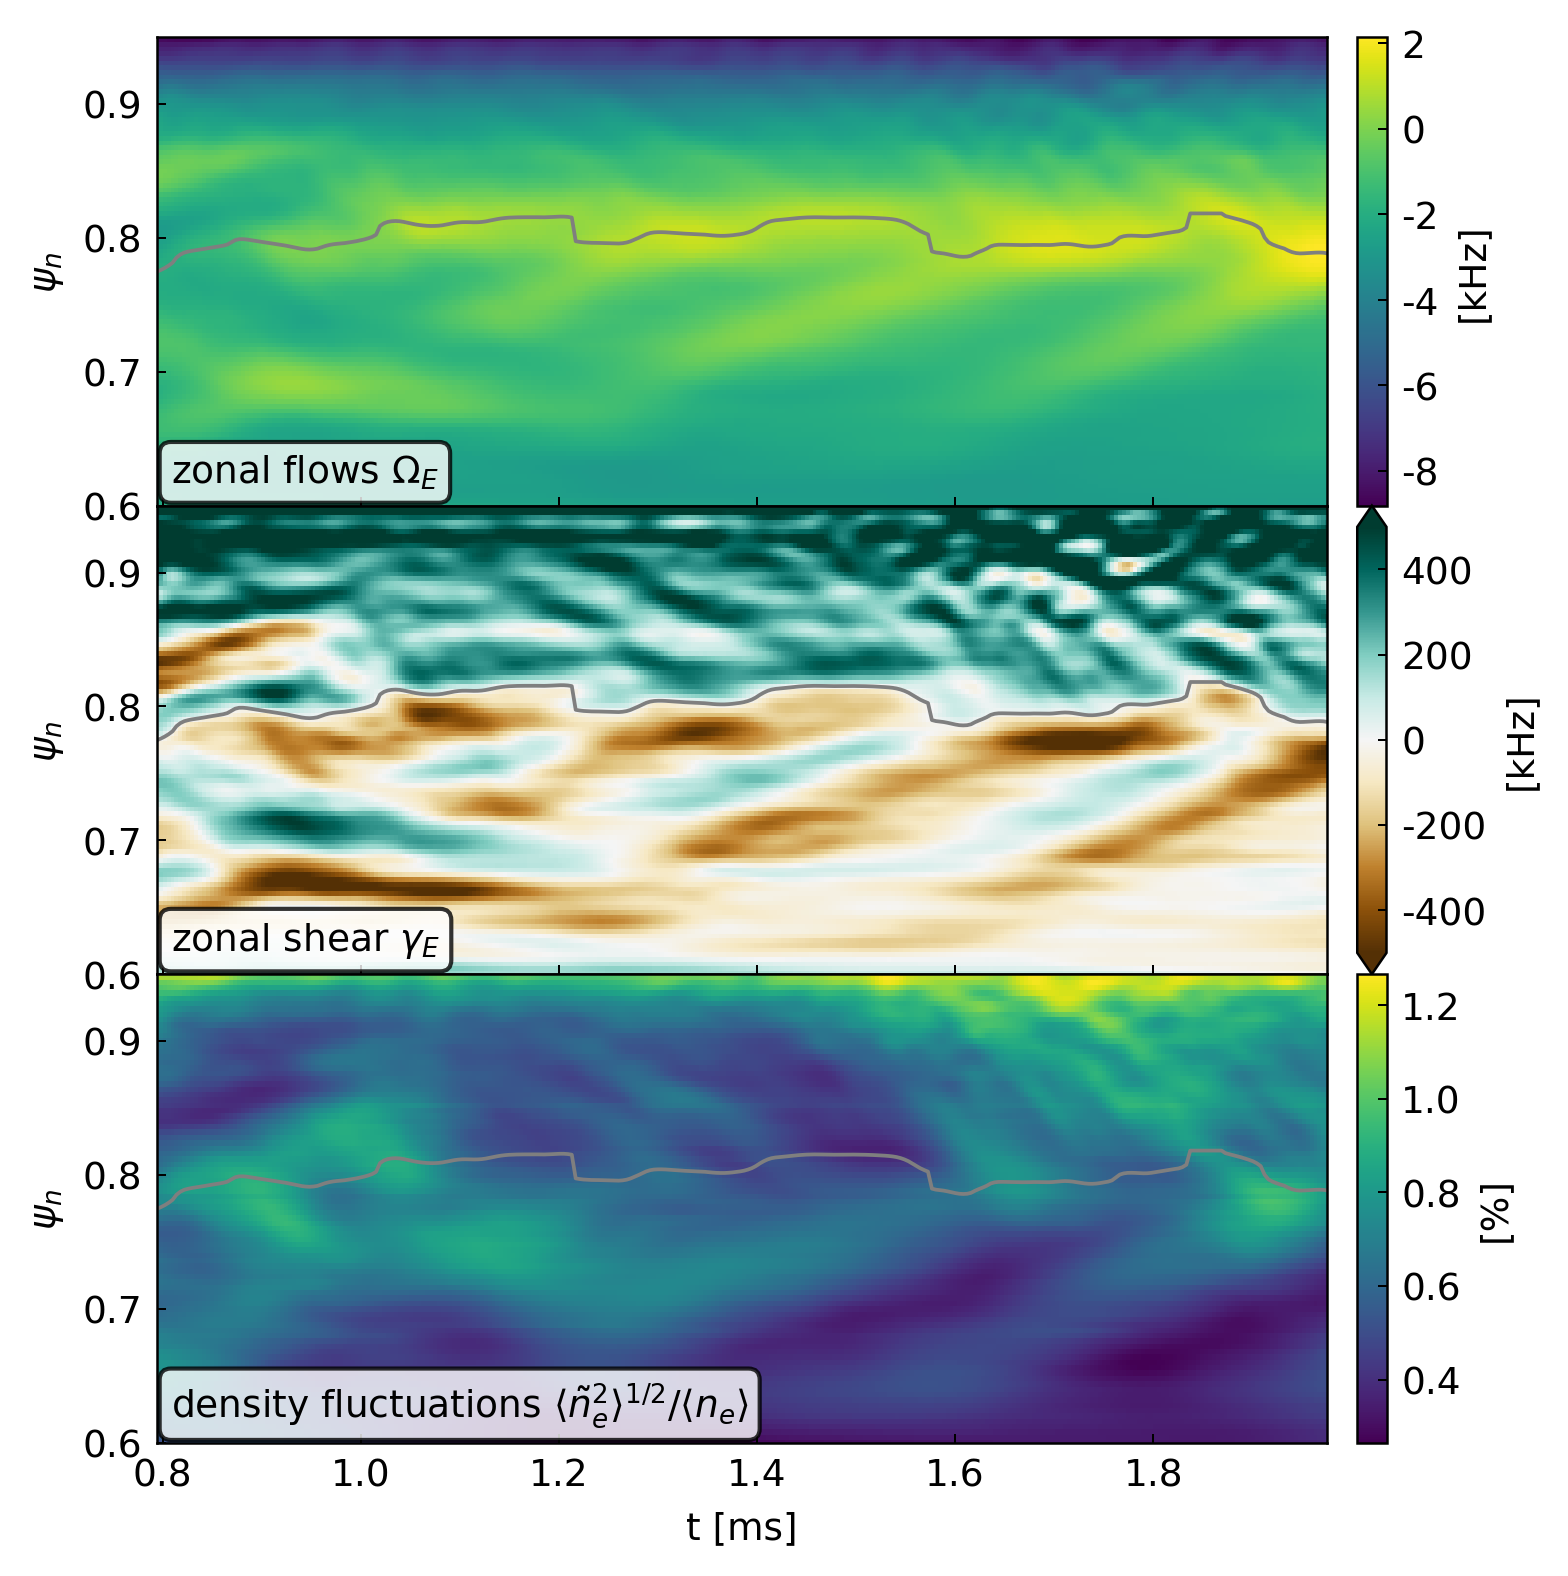

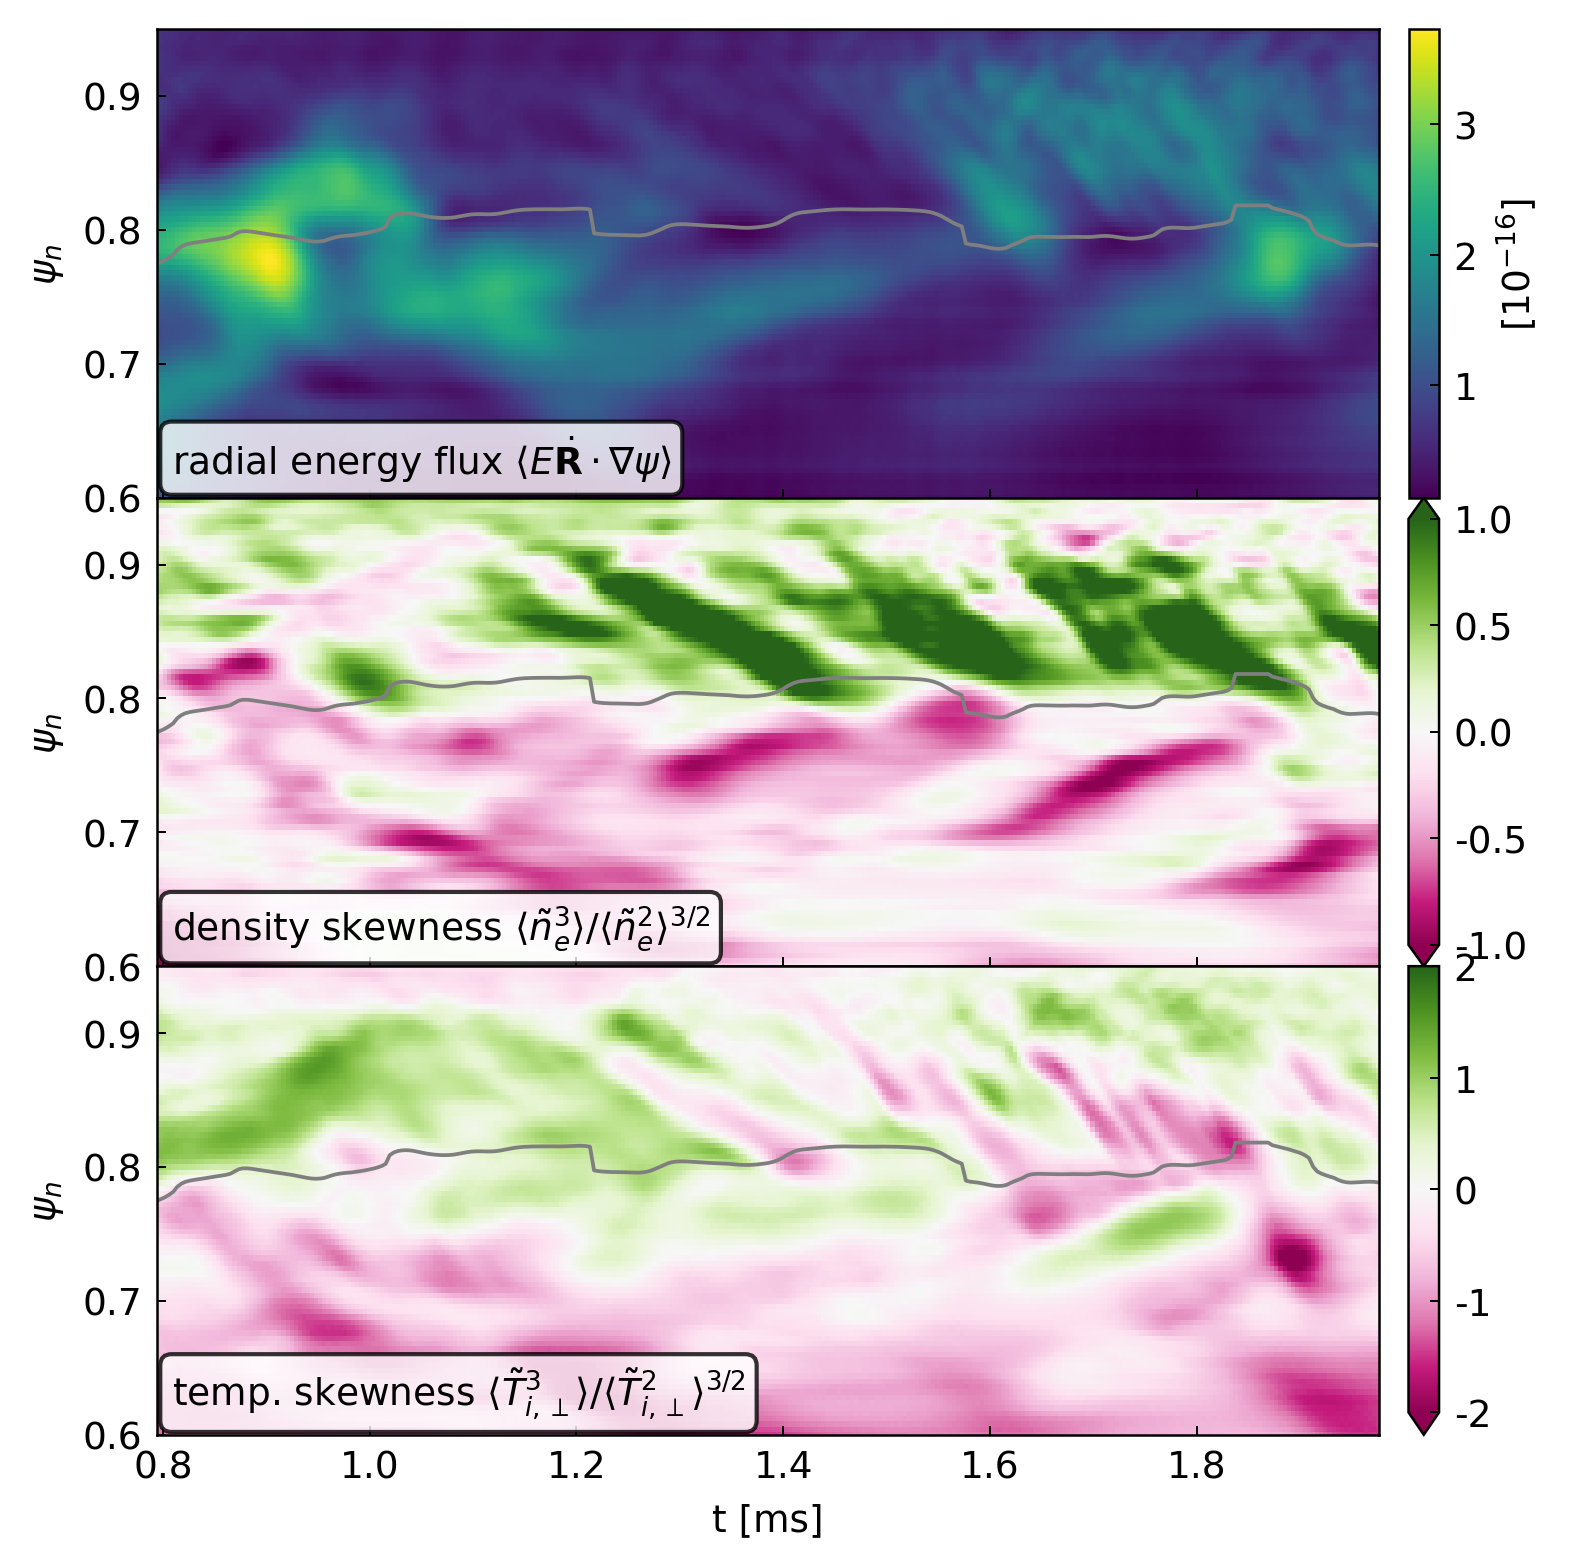

In [74]:
# %% Figures for slides

# Zonal jet, zonal shear, and density fluctuations

fig = plt.figure(figsize=(5.3, 5.3), dpi=300)
gs = mpl.gridspec.GridSpec(3, 2, figure=fig, width_ratios=[1, 0.025])

row = 0
ax, cax = fig.add_subplot(gs[row,0]), fig.add_subplot(gs[row,1])
plot_hovmoller(t*1e3, zpot_psi/eq.psix, -zfield.T*1e-3,
           cmap='viridis', ax=ax, cax=cax,
           label=R'zonal flows $\Omega_E$',
           cax_label=R'[kHz]', vmin=None, vmax=None)

row += 1
ax, cax = fig.add_subplot(gs[row,0], sharex=ax), fig.add_subplot(gs[row,1])
gamma_E = -dzfield_rtor*1e-3 * (geom.interp_q(zpot_psi) / interp_rho_tor(zpot_psi))[np.newaxis,:]
plot_hovmoller(t*1e3, zpot_psi/eq.psix, gamma_E.T,
           cmap='BrBG', ax=ax, cax=cax,
           label=R'zonal shear $\gamma_E$',
           cax_label=R'[kHz]', vmin=-500, vmax=500)

row += 1
ax, cax = fig.add_subplot(gs[row,0], sharex=ax), fig.add_subplot(gs[row,1])
e_den_fluct = np.sqrt(summary_data['e_den_var']/summary_data['e_den_avg']**2)
plot_hovmoller(t*1e3, geom.psi_surf/eq.psix, e_den_fluct.T*100,
           cmap='viridis', ax=ax, cax=cax,
           label=R'density fluctuations $\langle \tilde{n}_e^2 \rangle^{1/2} / \langle n_e \rangle$',
           cax_label=R'[%]', vmin=None, vmax=None)


ax.xaxis.set_tick_params(labelbottom=True)
ax.set_xlabel(R't [ms]')

plt.tight_layout(h_pad=0.0, w_pad=0.8)
plt.subplots_adjust(hspace=0.0)

plt.savefig('./outputs/jpp_figures/hovmoller_jet.pdf', dpi=300)
plt.savefig('./outputs/jpp_figures/hovmoller_jet.png', dpi=300)

# Avalanches

fig = plt.figure(figsize=(5.3, 5.3), dpi=300)
gs = mpl.gridspec.GridSpec(3, 2, figure=fig, width_ratios=[1, 0.025])

row = 0
ax, cax = fig.add_subplot(gs[row,0], sharex=ax), fig.add_subplot(gs[row,1])
plot_hovmoller(t*1e3, psi_mks/eq.psix, (i_en_flux*1e16).T,
           cmap='viridis', ax=ax, cax=cax,
           label=R'radial energy flux $\langle E \dot{\mathbf{R}} \cdot \nabla \psi \rangle$',
           cax_label=R'$[10^{-16}]$', vmin=None, vmax=None)

row += 1
ax, cax = fig.add_subplot(gs[row,0], sharex=ax), fig.add_subplot(gs[row,1])
e_den_skwn = summary_data['e_den_skw'] / summary_data['e_den_var']**1.5
plot_hovmoller(t*1e3, geom.psi_surf/eq.psix, e_den_skwn.T,
           cmap='PiYG', ax=ax, cax=cax,
           label=R'density skewness $\langle \tilde{n}_e^3 \rangle / \langle \tilde{n}_e^2 \rangle^{3/2}$',
           cax_label=R'', vmin=-1, vmax=1)

row += 1
ax, cax = fig.add_subplot(gs[row,0], sharex=ax), fig.add_subplot(gs[row,1])
i_T_skwn = summary_data['i_T_perp_skw'] / summary_data['i_T_perp_var']**1.5
plot_hovmoller(t*1e3, geom.psi_surf/eq.psix, i_T_skwn.T,
           cmap='PiYG', ax=ax, cax=cax,
           label=R'temp. skewness $\langle \tilde{T}_{i,\perp}^3 \rangle / \langle \tilde{T}_{i,\perp}^2 \rangle^{3/2}$',
           cax_label=R'', vmin=-2, vmax=2)

ax.xaxis.set_tick_params(labelbottom=True)
ax.set_xlabel(R't [ms]')

plt.tight_layout(h_pad=0.0, w_pad=0.8)
plt.subplots_adjust(hspace=0.0)

plt.savefig('./outputs/jpp_figures/hovmoller_avalanches.pdf', dpi=300)
plt.savefig('./outputs/jpp_figures/hovmoller_avalanches.png', dpi=300)

#row += 1
#ax, cax = fig.add_subplot(gs[row,0], sharex=ax), fig.add_subplot(gs[row,1])
#e_gc_lne = -np.gradient(np.log(e_gc_den), axis=1) / np.gradient(psi_mks)
#plot_hovmoller(t*1e3, psi_mks/eq.psix, e_gc_lne.T,
#           cmap='viridis', ax=ax, cax=cax,
#           label=R'electron density gradient',
#           cax_label=R'', vmin=None, vmax=None)
#
#row += 1
#ax, cax = fig.add_subplot(gs[row,0], sharex=ax), fig.add_subplot(gs[row,1])
#i_T_perp_lne = -np.gradient(np.log(i_T_perp), axis=1) / np.gradient(psi_mks)
#plot_hovmoller(t*1e3, psi_mks/eq.psix, i_T_perp_lne.T,
#           cmap='viridis', ax=ax, cax=cax,
#           label=R'ion temp gradient',
#           cax_label=R'', vmin=None, vmax=None)



### Temporally-averaged plots

C:\Users\maple\AppData\Local\Temp\ipykernel_19144\3574296340.py:13: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(tor_flux(psi)/torx)
C:\Users\maple\AppData\Local\Temp\ipykernel_19144\3574296340.py:20: RuntimeWarning: invalid value encountered in sqrt
  rho_tor = np.sqrt(tor_flux(psi) / torx)


Zero crossing at psi_n ≈ 0.8023


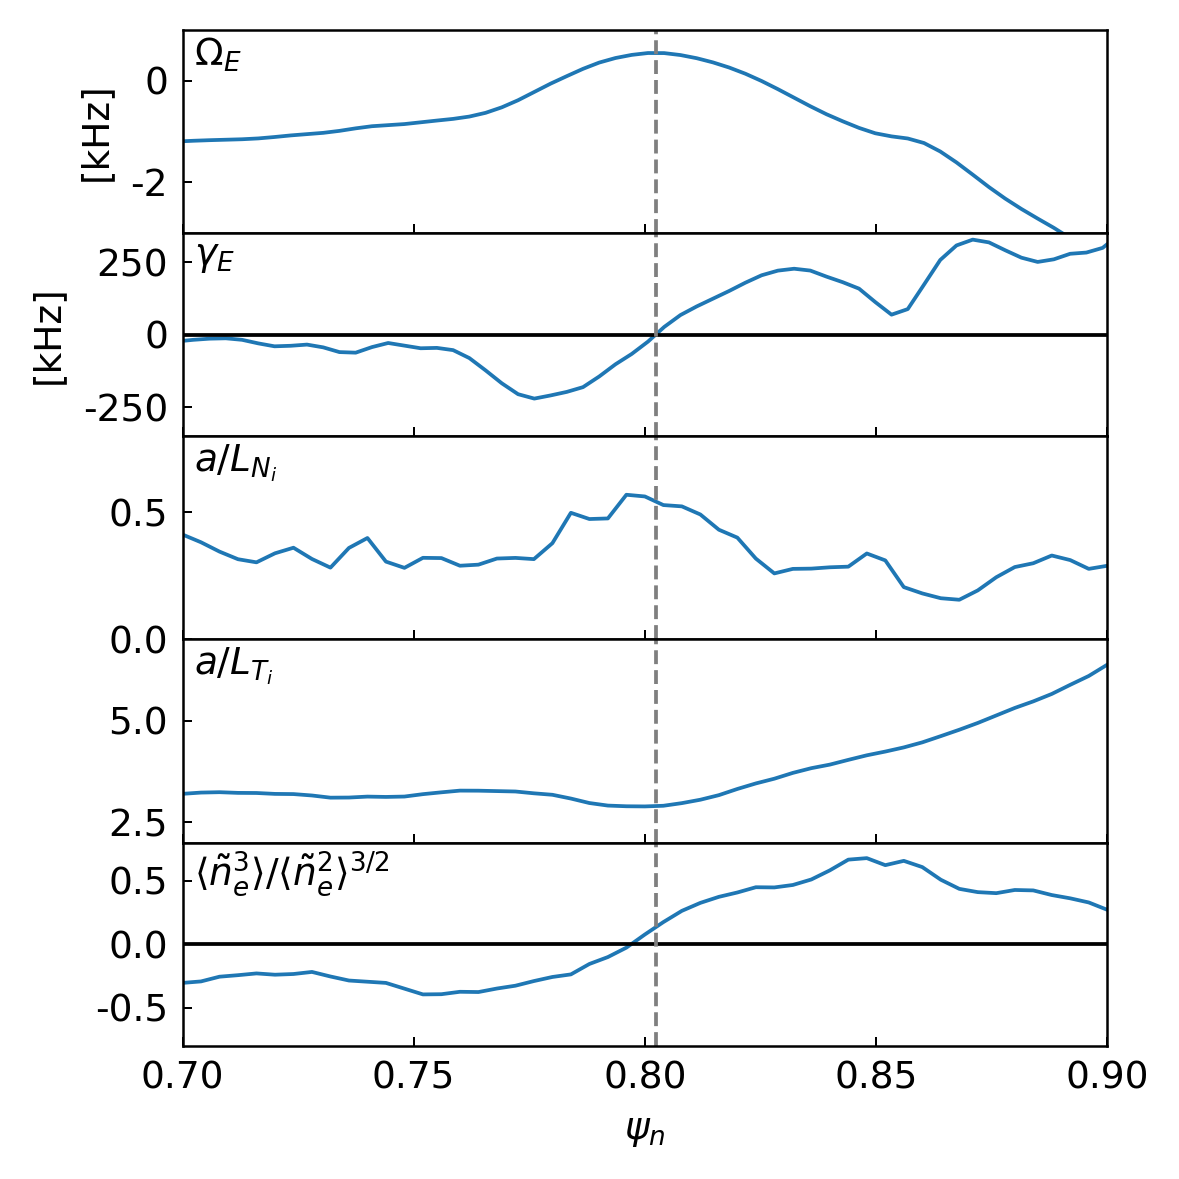

In [87]:
# %% Density skewness vs. shearless barrier

%matplotlib inline

text_props = {'x': 0.012, 'y': 0.97,
              'size': 9,
              'va': 'top', 'ha': 'left'}

fig = plt.figure(figsize=(4.0, 4.0), dpi=300)

gs = fig.add_gridspec(5, 1, hspace=0.0)

dzfield_avg = np.mean(dzfield_rtor[200:,:], axis=0)
gamma_E_avg = -dzfield_avg * (geom.interp_q(zpot_psi) / interp_rho_tor(zpot_psi))
dzfield_0 = np.mean(dzfield_rtor[:100,:], axis=0)
zfield_avg = np.mean(zfield[200:,:], axis=0)

# Find indices in the desired range
psi_norm = zpot_psi / eq.psix
mask = (psi_norm >= 0.75) & (psi_norm <= 0.85)
psi_in_range = psi_norm[mask]
dzfield_in_range = dzfield_avg[mask]

# Find zero crossing: where the sign changes
zero_crossings = np.where(np.diff(np.sign(dzfield_in_range)))[0]
if len(zero_crossings) > 0:
    # Linear interpolation for more accurate zero crossing
    i = zero_crossings[0]
    x0, x1 = psi_in_range[i], psi_in_range[i+1]
    y0, y1 = dzfield_in_range[i], dzfield_in_range[i+1]
    psi_zero = x0 - y0 * (x1 - x0) / (y1 - y0)
    print(f"Zero crossing at psi_n ≈ {psi_zero:.4f}")
else:
    psi_zero = None
    print("No zero crossing found in the specified range.")

## Plot zonal flows
row = 0
ax = fig.add_subplot(gs[row])
#ax.plot(zpot_psi/eq.psix, -dzfield_0*1e-3, label=R'$t < ' + F"{t[100]*1e3:.3f}" + '$ ms')
ax.plot(zpot_psi/eq.psix, -zfield_avg*1e-3, label=R'$t > ' + F"{t[200]*1e3:.3f}" + '$ ms')

#ax.axhline(0, color='k')
ax.set_xlim(0.7, 0.9)
ax.set_ylim(-3, 1)
ax.xaxis.set_tick_params(labelbottom=False)
ax.axvline(psi_zero, color='tab:gray', linestyle='--')
ax.set_ylabel(R'[kHz]')

ax.text(s=R'$\Omega_E$', transform=ax.transAxes, **text_props)


## Plot zonal flow shear
row += 1
ax = fig.add_subplot(gs[row], sharex=ax)
#ax.plot(zpot_psi/eq.psix, -dzfield_0*1e-3, label=R'$t < ' + F"{t[100]*1e3:.3f}" + '$ ms')
ax.plot(zpot_psi/eq.psix, gamma_E_avg*1e-3, label=R'$t > ' + F"{t[200]*1e3:.3f}" + '$ ms')

ax.axhline(0, color='k')
#ax.set_xlim(0.7, 0.9)
ax.set_ylim(-350, 350)
ax.xaxis.set_tick_params(labelbottom=False)
ax.axvline(psi_zero, color='tab:gray', linestyle='--')
ax.set_ylabel(R'[kHz]')

#ax.legend(loc='lower left')

ax.text(s=R'$\gamma_E$', transform=ax.transAxes, **text_props)

## Plot ion gc density gradient
row += 1
ax = fig.add_subplot(gs[row], sharex=ax)

i_den_avg = np.mean(i_gc_den[200:,:], axis=0)
grad_i_den = -rho_tor_gradient(psi_mks, np.log(i_den_avg))
grad_i_den0 = -rho_tor_gradient(psi_mks, np.log(np.mean(i_gc_den[:100,:], axis=0)))

#ax.plot(psi_mks/eq.psix, grad_i_den0)
ax.plot(psi_mks/eq.psix, grad_i_den)
ax.set_ylim(0, 0.8)
ax.xaxis.set_tick_params(labelbottom=False)
ax.axvline(psi_zero, color='tab:gray', linestyle='--')
ax.text(s=R'$a/L_{N_i}$', transform=ax.transAxes, **text_props)

## Plot ion temperature gradient
row += 1
ax = fig.add_subplot(gs[row], sharex=ax)

i_T_avg = np.mean(i_T_perp[200:,:], axis=0)
grad_i_T = -rho_tor_gradient(psi_mks, np.log(i_T_avg))
grad_i_T0 = -rho_tor_gradient(psi_mks, np.log(np.mean(i_T_perp[:100,:], axis=0)))

#ax.plot(psi_mks/eq.psix, grad_i_T0)
ax.plot(psi_mks/eq.psix, grad_i_T)
ax.set_ylim(2.0, 7.0)
ax.xaxis.set_tick_params(labelbottom=False)
ax.axvline(psi_zero, color='tab:gray', linestyle='--')
ax.text(s=R'$a/L_{T_i}$', transform=ax.transAxes, **text_props)


## Plot density skewness
row += 1
ax = fig.add_subplot(gs[row], sharex=ax)

e_den_skwn = summary_data['e_den_skw'] / summary_data['e_den_var']**1.5
e_den_skwn_avg = np.mean(e_den_skwn[200:,:], axis=0)
e_den_skwn_0 = np.mean(e_den_skwn[:100,:], axis=0)
#ax.plot(geom.psi_surf/eq.psix, e_den_skwn_0)
ax.plot(geom.psi_surf/eq.psix, e_den_skwn_avg)

ax.axhline(0, color='k')
ax.set_ylim(-0.8, 0.8)
ax.xaxis.set_tick_params(labelbottom=False)
ax.axvline(psi_zero, color='tab:gray', linestyle='--')
ax.text(s=R'$\langle \tilde{n}_e^3 \rangle / \langle \tilde{n}_e^2 \rangle^{3/2}$', transform=ax.transAxes, **text_props)


"""
## Plot flow
row += 1
ax = fig.add_subplot(gs[row], sharex=ax)

ax.plot(psi_mks/eq.psix, np.mean(i_parallel_flow[:100,:], axis=0))
ax.plot(psi_mks/eq.psix, np.mean(i_parallel_flow[200:,:], axis=0))
#ax.set_ylim(2.0, 7.0)
ax.xaxis.set_tick_params(labelbottom=False)
ax.axvline(psi_zero, color='tab:gray', linestyle='--')
#ax.text(s=R'$a/L_{T_i}$', transform=ax.transAxes, **text_props)
"""

ax.xaxis.set_tick_params(labelbottom=True)
ax.set_xlabel(R'$\psi_n$')

# Combine legends from both axes
#lines, labels = ax.get_legend_handles_labels()
#lines2, labels2 = axt.get_legend_handles_labels()
#ax.legend(lines + lines2, labels + labels2, loc='upper left')



plt.tight_layout()
plt.savefig('./outputs/jpp_figures/plot_shearless_comparison.pdf', dpi=300)
plt.savefig('./outputs/jpp_figures/plot_shearless_comparison.png', dpi=300)

In [ ]:
# %% Get reference data for profile plots

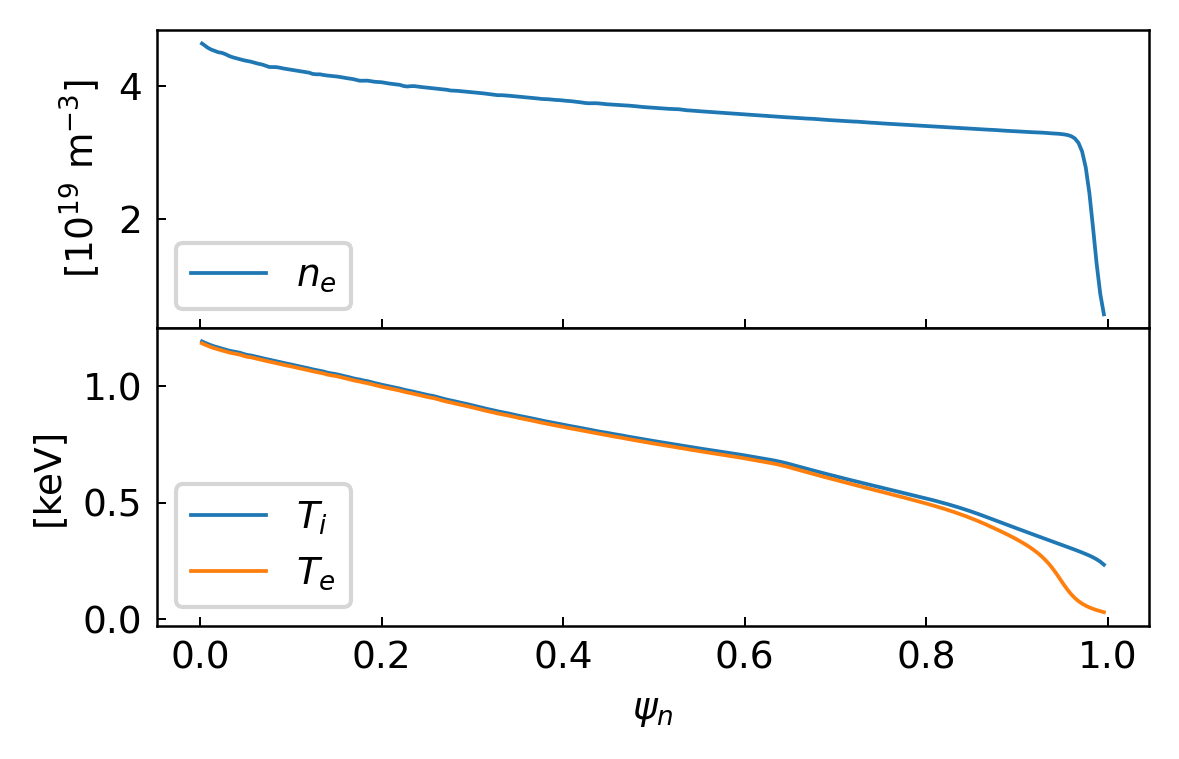

In [32]:
# %% Profile plots

fig = plt.figure(figsize=(4.0, 2.6), dpi=300)

gs = fig.add_gridspec(2, 1, hspace=0.0)

ind_max = np.searchsorted(psi_mks/eq.psix, 1.0)+1

## Electron density
row = 0
ax = fig.add_subplot(gs[row])
#ax.plot(psi_mks[:ind_max]/eq.psix, e_gc_den[0,:ind_max]*1e-19, label=R'$n_e$')
ax.plot(geom.psi_surf/eq.psix, den_0*1e-19, label=R'$n_e$')
ax.xaxis.set_tick_params(labelbottom=False)
ax.legend(loc='lower left')

ax.set_ylabel(R'[10$^{19}$ m$^{-3}$]')

## Electron and ion temperature
row += 1
ax = fig.add_subplot(gs[row], sharex=ax)
#ax.plot(psi_mks[:ind_max]/eq.psix, i_T_perp[0,:ind_max]*1e-3, label=R'$T_{i}$')
#ax.plot(psi_mks[:ind_max]/eq.psix, e_T_perp[0,:ind_max]*1e-3, label=R'$T_{e}$')
ax.plot(geom.psi_surf/eq.psix, i_T_ev_0*1e-3, label=R'$T_{i}$')
ax.plot(geom.psi_surf/eq.psix, e_T_ev_0*1e-3, label=R'$T_{e}$')
ax.legend(loc='lower left')

ax.set_ylabel(R'[keV]')

ax.set_xlabel(R'$\psi_n$')


plt.tight_layout()
plt.savefig('./outputs/jpp_figures/plot_equilibrium.pdf', dpi=300)
plt.savefig('./outputs/jpp_figures/plot_equilibrium.png', dpi=300)

### Toroidal Mode Spectrum

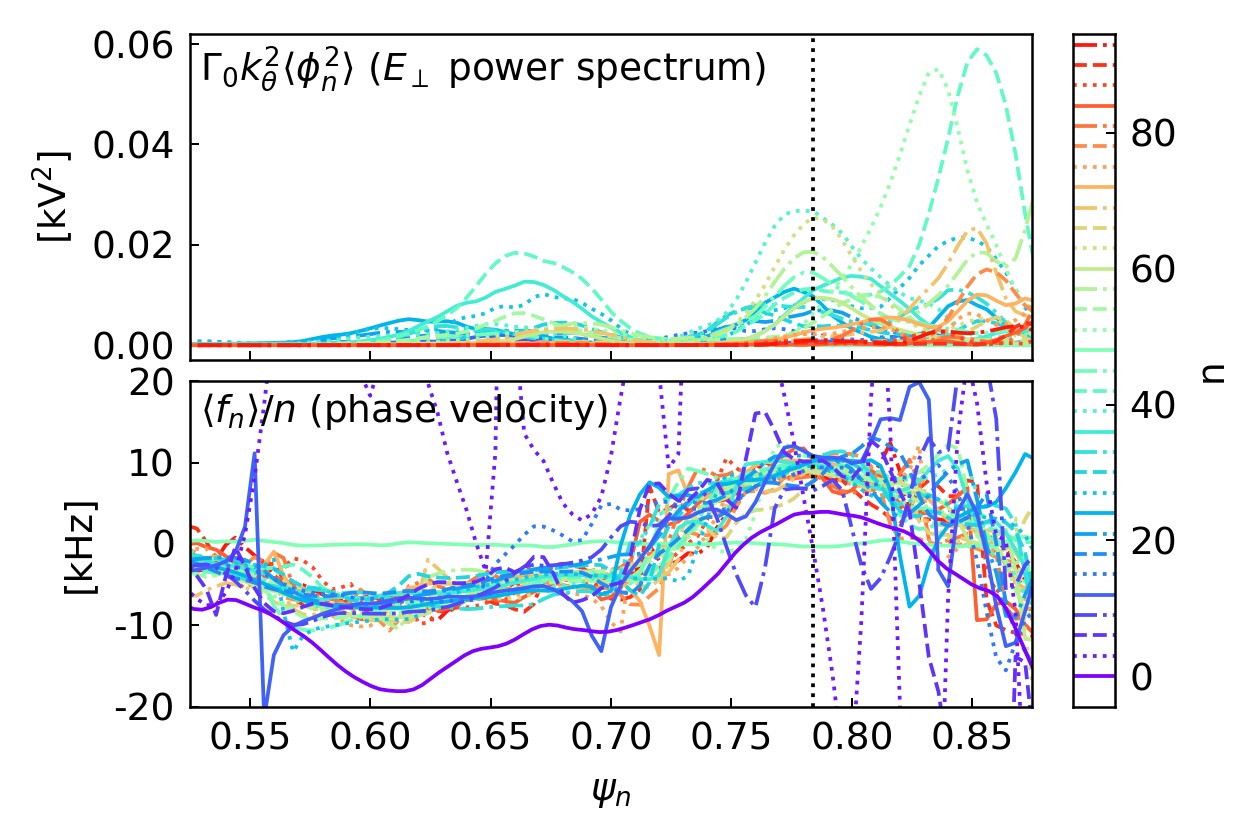

In [97]:
# %% Toroidal mode spectra plot

## Load data
dpot_spectra = np.load('./outputs/dpot_spectra.npz')
dpot_power = dpot_spectra['dpot_power']
dpot_mult = dpot_spectra['dpot_mult']

ksurf0, ksurf1 = 1, geom.nsurf

## Set up the figure via a subplot mosaic
fig = plt.figure(figsize=(4.0, 2.6), dpi=300)
ax_dict = fig.subplot_mosaic(
    [
        ["power", "cax"],
        ["vph", "cax"],
    ],
    width_ratios=[1, 0.05],
    sharex=True,
)

ax = ax_dict['power']
cax = ax_dict['cax']
ax2 = ax_dict['vph']

## Function for setting the line styles
linestyles = ['solid', 'dotted', 'dashed', 'dashdot']
def nstyle(n):
    return {
        'linestyle': linestyles[n%4],
        'color': mpl.cm.rainbow(n/(dpot_power.shape[1]-1)),
    }

## Plot the power spectrum and phase velocities
dt = xgcdata['t'][tind] - xgcdata['t'][tind-1]

for n in range(dpot_power.shape[1]-1):
    # Compute ktheta
    rho = interp_rho_tor(geom.psi_surf[ksurf0:ksurf1-20]) * amin
    ktheta = 3 * n * geom.interp_q(geom.psi_surf[ksurf0:ksurf1-20]) / rho

    # Compute rho_i
    bv = eq.compute_bv(eq.interp_router(geom.psi_surf[ksurf0:ksurf1-20]/eq.psix), eq.zaxis * np.ones(ksurf1-ksurf0-20))
    # Compute ion gyroradius at outboard midplane
    pp = particle_motion.deut
    cyc_freq_i = pp.z * np.linalg.norm(bv, axis=0) / pp.m
    rho_i = pp.vt / cyc_freq_i * np.sqrt(i_T_ev_0[ksurf0:ksurf1-20]*1e-3)
    # Use Gamma_0(b) = I_0(b) exp(-b) to compute the gyroaverage factor
    gyroaverage_factor = scipy.special.ive(0, (ktheta * rho_i)**2)

    ax.plot(geom.psi_surf[ksurf0:ksurf1-20]/eq.psix, np.abs(dpot_power[:-20,n])*(ktheta*1e-3)**2*gyroaverage_factor, **nstyle(n))
    cax.axhline(n*3, **nstyle(n))
for n in reversed(range(1,dpot_power.shape[1]-1)):
    ax2.plot(geom.psi_surf[ksurf0:ksurf1]/eq.psix, np.angle(dpot_mult[:,n])/(3*n)/dt*2*np.pi*1e-3, **nstyle(n))

# Add annotation lines to the plots
ax.axvline(geom.psi_surf[196]/eq.psix, c='k', ls=':')
ax2.axvline(geom.psi_surf[196]/eq.psix, c='k', ls=':')
ax2.plot(zpot_psi/eq.psix, -zfield[400,:]*2*np.pi*1e-3, c=mpl.cm.rainbow(0))
#ax2.axhline(0, c='k')
#cax.axhline(0, **nstyle(0))

## Set up labeling and such

# Set the cax tick labels to the right
cax.yaxis.set_ticks_position('right')
cax.yaxis.set_label_position('right')
cax.set_ylabel('n')
cax.xaxis.set_visible(False)

# Axis limits
ax.set_xlim(0.525,0.875)
ax2.set_ylim(-20,20)

# Axis labels
ax2.set_xlabel(R'$\psi_n$')
ax.set_ylabel(R'[kV${}^2$]')
ax.text(s=R'$\Gamma_0 k_\theta^2 \langle\phi_n^2\rangle$ ($E_\perp$ power spectrum)', transform=ax.transAxes, **text_props)
ax2.set_ylabel(R'[kHz]')
ax2.text(s=R'$\langle f_n\rangle / n$ (phase velocity)', transform=ax2.transAxes, **text_props)
#ax.set_title('Toroidal Mode Spectrum')
#ax2.set_title('Phase Velocity')

## Save data and figure
np.savez('./outputs/dpot_spectra.npz', dpot_power=dpot_power, dpot_mult=dpot_mult)

plt.tight_layout(pad=0.0, w_pad=1.08)
plt.tight_layout(pad=0.0, w_pad=1.08)


plt.savefig('./outputs/jpp_figures/plot_dpot_spectra.pdf', dpi=300)
plt.savefig('./outputs/jpp_figures/plot_dpot_spectra.png', dpi=300)

## Poloidal Cross Section Plots

### Loading and Processing Data

In [4]:
# %% Load fluctuation data and compute the upsampled FFT of the potential

## Load the potential
tind = 400
dpot = xgcdata['dpot'][tind,:,:]

# Compute the upsampled FFT of the potential
dpot_fft = upsample_fft_dpot(dpot, geom)

In [4]:
# %% Load poincare section data along with distribution function data

with open('./outputs/sections/midplane_deut_trapped_r100.pkl', 'rb') as f:
    section_data = pickle.load(f)

ppunc2 = section_data['ppunc2']
npunc2 = section_data['npunc2']
ravgs = section_data['ravgs']

f_trapped = np.load(R'F:\Documents\IFS\hmode_jet\outputs\f_xgc_trapped.npz')
fp_physical = f_trapped['fp_physical']
fn_physical = f_trapped['fn_physical']
f_mask = f_trapped['f_mask']
xi_grid = f_trapped['xi_grid']

f_passing = np.load(R'F:\Documents\IFS\hmode_jet\outputs\f_xgc_passing.npz')
fn_physical_passing = f_passing['fn_physical']

In [5]:
# %% Check range of psi surfaces hit by the particles

ppunc2 = section_data['ppunc2']
npunc2 = section_data['npunc2']

psi_min = np.inf
psi_max = -np.inf

for k in range(0,48):
    r = np.concatenate((npunc2[k][1][0,:], ppunc2[k][1][0,:]))
    z = np.concatenate((npunc2[k][1][2,:], ppunc2[k][1][2,:]))
    psi = eq.interp_psi(r, z, grid=False)

    psi_min = min(psi_min, np.min(psi))
    psi_max = max(psi_max, np.max(psi))

print(f'Minimum psi: {psi_min/eq.psix:.3f}, Maximum psi: {psi_max/eq.psix:.3f}')

ksurf0, ksurf1 = np.searchsorted(geom.psi_surf, (psi_min, psi_max))
print(ksurf0, ksurf1)

Minimum psi: 0.714, Maximum psi: 0.858
179 215


In [6]:
# %% Load f3d data

f3d_file = R"F:\Documents\Globus\XGC1_HD3D_elec_rgn1_run4\xgc.f3d.08000.bp"

with FileReader(f3d_file) as s:
    ## inspect variables
    vars = s.available_variables()
    for name, info in vars.items():
        print("variable_name: " + name, end=" ")
        for key, value in info.items():
            print("\t" + key + ": " + value, end=" ")
        print()
    print()

    # Load field data
    e_den = s.read('e_den', start=[0, 0], count=[132048, 1])
    dpot_f3d = s.read('dpot', start=[0, 0], count=[132048, 1])
    e_T_para = s.read('e_T_para', start=[0, 0], count=[132048, 1])

variable_name: dpot 	AvailableStepsCount: 1 	Max: 56.4656 	Min: -27.4515 	Shape: 132048, 16 	SingleValue: false 	Type: double 
variable_name: e_ExB_enflux_en 	AvailableStepsCount: 1 	Max: 6939.91 	Min: -1972.18 	Shape: 132048, 9 	SingleValue: false 	Type: double 
variable_name: e_ExB_flux_en 	AvailableStepsCount: 1 	Max: 3.06801e+19 	Min: -5.69339e+19 	Shape: 132048, 9 	SingleValue: false 	Type: double 
variable_name: e_T_para 	AvailableStepsCount: 1 	Max: 1184.39 	Min: 0.0327014 	Shape: 132048, 16 	SingleValue: false 	Type: double 
variable_name: e_T_perp 	AvailableStepsCount: 1 	Max: 1180.95 	Min: 0.193254 	Shape: 132048, 16 	SingleValue: false 	Type: double 
variable_name: e_den 	AvailableStepsCount: 1 	Max: 4.64131e+19 	Min: 5.43334e+15 	Shape: 132048, 16 	SingleValue: false 	Type: double 
variable_name: e_den_en 	AvailableStepsCount: 1 	Max: 1.75574e+19 	Min: 0 	Shape: 132048, 9 	SingleValue: false 	Type: double 
variable_name: e_energy_en 	AvailableStepsCount: 1 	Max: 5.80275e+33

In [ ]:
# %% Plot properties

ax_xlim = [np.min(geom.rz_node[:,0]), np.max(geom.rz_node[:,0])]
ax_ylim = [np.min(geom.rz_node[:,1]), np.max(geom.rz_node[:,1])]

ax_xlim = [ax_xlim[0] - 0.05*(ax_xlim[1]-ax_xlim[0]), ax_xlim[1] + 0.05*(ax_xlim[1]-ax_xlim[0])]
ax_ylim = [ax_ylim[0] - 0.05*(ax_ylim[1]-ax_ylim[0]), ax_ylim[1] + 0.05*(ax_ylim[1]-ax_ylim[0])]

text_bbox = {'facecolor': 'white',
             'alpha': 0.8,
             'boxstyle': 'round'}
text_props = {'x': 0.02, 'y': 0.99,
              'size': 9,
              'va': 'top', 'ha': 'left',
              'bbox': text_bbox}

cax_bound = [0.54, 0.1, 0.4, 0.02]

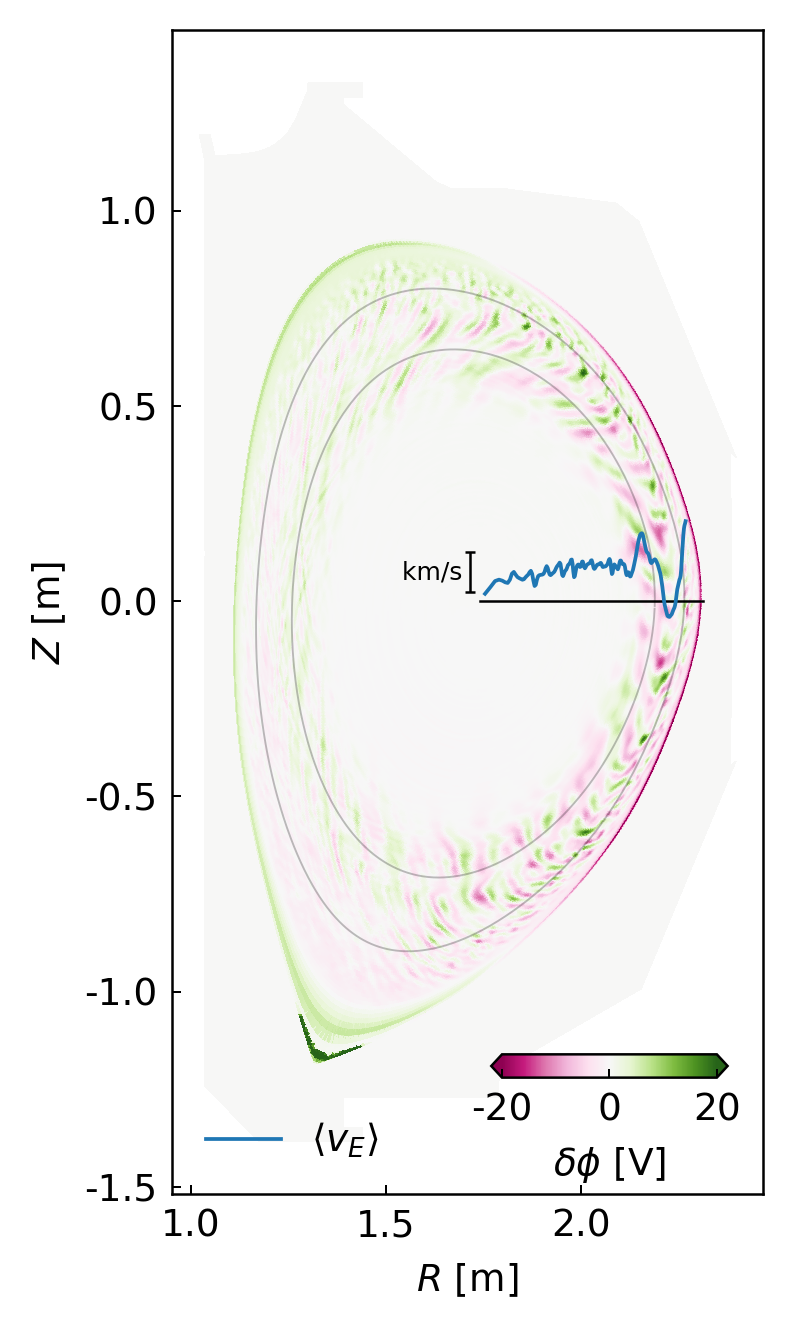

In [57]:
# %% Plot the potential fields

def plot_poloidal_dpot(ax: mpl.axes.Axes):
    ax.set_aspect('equal')
    ax.yaxis.set_tick_params(labelleft=False)
    ax.set_xlabel(R'$R$ [m]')

    ## Plot the non-zonal component of the potential
    pc = ax.tripcolor(geom.rz_tri, dpot_f3d[:,0], cmap='PiYG', vmin=-20, vmax=20, rasterized=True)

    ## Plot lines demarcating the region of interest
    ksurf = 179-5
    rz_surf = geom.rz_node[geom.breaks_surf[ksurf]:geom.breaks_surf[ksurf+1],:]
    ax.plot(rz_surf[:,0], rz_surf[:,1], c='k', alpha=0.25, lw=mpl.rcParams['lines.linewidth']*0.5)

    ksurf = 216+5
    rz_surf = geom.rz_node[geom.breaks_surf[ksurf]:geom.breaks_surf[ksurf+1],:]
    ax.plot(rz_surf[:,0], rz_surf[:,1], c='k', alpha=0.25, lw=mpl.rcParams['lines.linewidth']*0.5)

    ## Overplot the ExB flows

    # Plot a reference line for the ZFs
    ax.plot([eq.raxis, np.max(eq.lcfsrz[:,0])], [0.0, 0.0], c='k', lw=linescale)
    ax.errorbar(eq.raxis-0.025, 0.075, yerr=0.05, fmt='', color='k', lw=linescale, capsize=2.0*linescale, capthick=linescale)

    # Label the reference line
    ax.text(eq.raxis-0.025, 0.075, R'km/s ', transform=ax.transData, size=6,
            ha='right', va='center',)

    # Compute the zonal flows

    # Compute the magnetic stuff necessary to compute the zonal flows
    r = eq.interp_router(zpot_psi/eq.psix)
    z = np.zeros_like(r)

    psi_ev, ff_ev = eq.compute_psi_and_ff(r, z)
    (psi, psidr, psidz, psidrr, psidrz, psidzz) = psi_ev
    modpsi = np.sqrt(psidr**2 + psidz**2)

    bv = eq.compute_bv(r, z)
    modb = np.linalg.norm(bv, axis=0)
    
    v_exb = zfield[400,:] * modpsi / modb

    # Actually plot the zonal flows
    zind_max = int(len(zpot_psi)*0.85)
    zscale = 1e-4
    ax.plot(r[:zind_max], zscale * v_exb[:zind_max], c='tab:blue', label=R'$\langle v_{E}\rangle$')


    ## Add the colorbar
    cax = ax.inset_axes(cax_bound)
    plt.colorbar(pc, cax=cax, orientation='horizontal', extend='both', label=R'$\delta \phi$ [V]')
    ax.legend(loc='lower left', frameon=False)
    

def plot_poloidal_dpot_fft(ax: mpl.axes.Axes):
    ax.set_aspect('equal')
    ax.yaxis.set_tick_params(labelleft=False)

    ax.tripcolor(geom.rz_tri, np.real(dpot_fft[13,:]), cmap='PiYG')

fig = plt.figure(figsize=(2.7,4.5), dpi=300)
gs = mpl.gridspec.GridSpec(1, 1, figure=fig)

col = 0
ax = fig.add_subplot(gs[col])
plot_poloidal_dpot(ax)

ax.yaxis.set_tick_params(labelleft=True)
ax.set_ylabel(R'$Z$ [m]')

#col += 1
#ax = fig.add_subplot(gs[col], sharex=ax, sharey=ax)
#plot_poloidal_dpot_fft(ax)

plt.tight_layout(h_pad=0.0, w_pad=0.0)

plt.savefig('./outputs/jpp_figures/poloidal_jet.pdf', dpi=300)
plt.savefig('./outputs/jpp_figures/poloidal_jet.png', dpi=300)

225671944.28570253 325257275.5696023
230992335.64918366 330404277.08572334


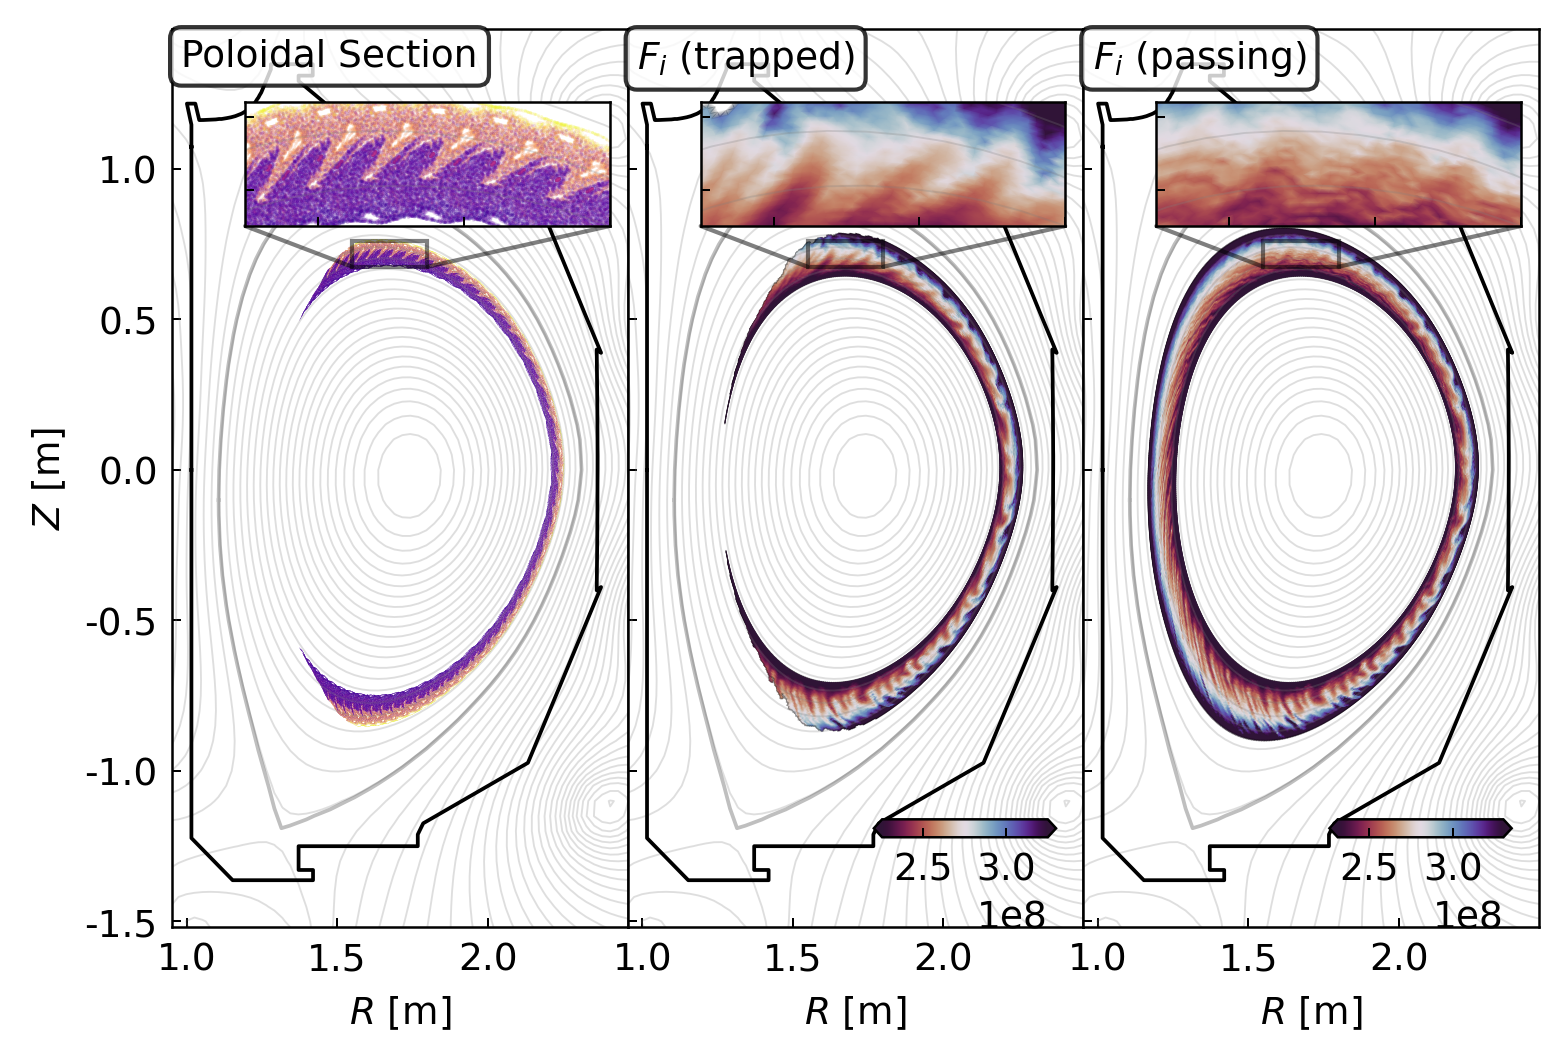

In [ ]:
# %% Plot the distribution function versus poloidal section

ins_xlim = [1.55, 1.8]
ins_ylim = [0.675, 0.76]
ins_bound = [0.16, 0.77, 0.8, 0.16]

def plot_poloidal_f(ax: mpl.axes.Axes, f_plot: np.ndarray, label: str):
    
    ## Set up the inset axis for zoom
    axins = ax.inset_axes(ins_bound, xticklabels=[], yticklabels=[])

    ## Plot flux surfaces
    eq.plot_magnetic_geometry(ax, alpha=0.25)
    eq.plot_magnetic_geometry(axins, alpha=0.25)

    ## Set up limits for inset axis
    axins.set_xlim(ins_xlim)
    axins.set_ylim(ins_ylim)
    ax.indicate_inset_zoom(axins, edgecolor="black")

    ## Set up info for colormap
    f_max = np.nanpercentile([f_plot], 88)
    f_min = np.nanpercentile([f_plot], 10)

    print(f_min, f_max)

    tw_repeated = mpl.cm.twilight(np.mod(np.linspace(0, 2, 256),1))
    twr_cmap = mpl.colors.LinearSegmentedColormap.from_list('twilight_repeated', tw_repeated, N=256)
    twr_cmap = mpl.cm.twilight_shifted_r
    #twr_cmap = mpl.cm.plasma

    ## Plot the distribution function
    pc = ax.tripcolor(geom.rz_tri, f_plot, shading='gouraud', rasterized=True, cmap=twr_cmap, vmin=f_min, vmax=f_max)
    axins.tripcolor(geom.rz_tri, f_plot, shading='gouraud', rasterized=True, cmap=twr_cmap, vmin=f_min, vmax=f_max)

    ax.set_xlim(ax_xlim)
    ax.set_ylim(ax_ylim)

    ax.yaxis.set_tick_params(labelleft=False)
    ax.set_xlabel(R'$R$ [m]')

    ## Label the plots
    ax.text(s=label, transform=ax.transAxes, **text_props)

    cax = ax.inset_axes(cax_bound)
    plt.colorbar(pc, cax=cax, orientation='horizontal', extend='both')
    
def plot_poloidal_section(ax: mpl.axes.Axes, punc2):
    ## Set up the inset axis for zoom
    axins = ax.inset_axes(ins_bound, xticklabels=[], yticklabels=[])
    
    ## Plot flux surfaces
    eq.plot_magnetic_geometry(ax, alpha=0.25)
    eq.plot_magnetic_geometry(axins, alpha=0.25)

    ## Set up limits for inset axis
    axins.set_xlim(ins_xlim)
    axins.set_ylim(ins_ylim)
    ax.indicate_inset_zoom(axins, edgecolor="black")

    ## Set up info for colormap
    rmax = np.max(ravgs)
    rmin = np.min(ravgs)
    
    ## Plot particles
    for k in range(len(punc2)):
        norm = mpl.colors.Normalize(vmin=rmin, vmax=rmax)
        color = mpl.cm.plasma(norm(ravgs[k]))

        ax.scatter(punc2[k][1][0,:], punc2[k][1][2,:], s=1.0*(72/300.0)**2, lw=0, color=color, rasterized=True, alpha=0.05)
        axins.scatter(punc2[k][1][0,:], punc2[k][1][2,:], s=9.0*(72/300.0)**2, lw=0, color=color, rasterized=True, alpha=0.1)

    ax.set_xlim(ax_xlim)
    ax.set_ylim(ax_ylim)

    ax.yaxis.set_tick_params(labelleft=False)
    ax.set_xlabel(R'$R$ [m]')

    ## Label the plots
    ax.text(s='Poloidal Section', transform=ax.transAxes, **text_props)

fig = plt.figure(figsize=(5.3,3.6), dpi=300)
gs = mpl.gridspec.GridSpec(1, 3, figure=fig)


col = 0
ax = fig.add_subplot(gs[col])
plot_poloidal_section(ax, npunc2)


ax.yaxis.set_tick_params(labelleft=True)
ax.set_ylabel(R'$Z$ [m]')

col += 1
ax = fig.add_subplot(gs[col], sharex=ax, sharey=ax)
plot_poloidal_f(ax, fn_physical[:,0], label=R'$F_i$ (trapped)')

col += 1
ax = fig.add_subplot(gs[col], sharex=ax, sharey=ax)
plot_poloidal_f(ax, fn_physical_passing[:,0], label=R'$F_i$ (passing)')

plt.tight_layout(h_pad=0.0, w_pad=0.0)
plt.subplots_adjust(hspace=0.0, wspace=0.0)

plt.savefig('./outputs/jpp_figures/poloidal_barrier.pdf', dpi=300)
plt.savefig('./outputs/jpp_figures/poloidal_barrier.png', dpi=300)
    

In [ ]:
# %% Compute the cross-field drifts 

## Avalanche Frames

In [61]:
# %% Load distribution function data

tinds_blob = [400, 410, 420, 430, 440] # <-- this one works the best so far
#tinds = [430, 440, 450, 460, 470, 480, 490, 495]
#tinds = [405, 410, 415, 420, 425, 430, 435, 440]
#tinds = [330, 340, 350, 360, 370, 380, 390, 400]
f_data = []

p1_lower_data = []
p0_lower_data = []

for tind in tinds_blob:
    f_analysis_data = np.load(R'F:\Documents\IFS\hmode_jet\outputs\phase_space_analysis_trapped\phase_space_{:04d}.npz'.format(tind))
    f_data.append(f_analysis_data['f_phi'])
    ksurf0 = f_analysis_data['ksurf0']
    ksurf1 = f_analysis_data['ksurf1']

    with open(f'F:/Documents/IFS/hmode_jet/outputs/phase_space_analysis_trapped/persistence_diagram_{tind}.pkl', 'rb') as f:
        p_all = pickle.load(f)

    pp_lower = []
    pn_lower = []
    pp_upper = []
    pn_upper = []

    for p_list in p_all:
        pp_lower.extend(p_list[0])
        pn_lower.extend(p_list[1])
        pp_upper.extend(p_list[2])
        pn_upper.extend(p_list[3])

    p1_lower = np.array(sorted(list(p[1] for p in (pp_lower+pn_lower) if p[0] == 1 and np.isfinite(p[1][1])), key=lambda p: p[0]-p[1]))
    p0_lower = np.array(sorted(list(p[1] for p in (pp_lower+pn_lower) if p[0] == 0 and np.isfinite(p[1][1])), key=lambda p: p[0]-p[1]))

    p1_lower_data.append(p1_lower)
    p0_lower_data.append(p0_lower)

In [62]:
# %% Get a subtriangulation

sub_triangles = geom.rz_tri.triangles - geom.breaks_surf[ksurf0]
mask_triangles = np.any(np.logical_or(sub_triangles < 0, sub_triangles >= (geom.breaks_surf[ksurf1+1]-geom.breaks_surf[ksurf0])), axis=1)
sub_triangles = sub_triangles[~mask_triangles,:]


In [63]:
# %% Generate silhouettes for phase space

tind_s0 = 100
sh_res = 512
s1_trapped_lower = np.empty(((500-tind_s0)//5, sh_res))
s0_trapped_lower = np.empty(((500-tind_s0)//5, sh_res))

sample_range = [2.25e8, 3.45e8]  # Range of the sample for the silhouette
SH = gudhi.representations.Silhouette(resolution=sh_res, sample_range=sample_range, weight=lambda x: np.power(np.abs(x[1]-x[0]),2))

for tind in tqdm(range(tind_s0, 500, 5)):
    with open(f'F:/Documents/IFS/hmode_jet/outputs/phase_space_analysis_trapped/persistence_diagram_{tind}.pkl', 'rb') as f:
        p_all = pickle.load(f)

    pp_lower = []
    pn_lower = []
    pp_upper = []
    pn_upper = []

    for p_list in p_all:
        pp_lower.extend(p_list[0])
        pn_lower.extend(p_list[1])
        pp_upper.extend(p_list[2])
        pn_upper.extend(p_list[3])

    p1_lower = np.array(sorted(list(p[1] for p in (pp_lower+pn_lower) if p[0] == 1 and np.isfinite(p[1][1])), key=lambda p: p[0]-p[1]))
    p0_lower = np.array(sorted(list(p[1] for p in (pp_lower+pn_lower) if p[0] == 0 and np.isfinite(p[1][1])), key=lambda p: p[0]-p[1]))

    
    sh = SH.fit_transform([p1_lower])
    s1_trapped_lower[(tind-tind_s0)//5,:] = sh.flatten()

    sh = SH.fit_transform([p0_lower])
    s0_trapped_lower[(tind-tind_s0)//5,:] = sh.flatten()

  0%|          | 0/80 [00:00<?, ?it/s]

In [90]:
# %% Prototyping some plots

%matplotlib qt
import matplotlib.patheffects as path_effects

# coordinates for the blob
blob_coords = [
    [-0.427, 0.8318, 3.50e8],
    [-0.376, 0.8186, 3.30e8],
    [-0.307, 0.8011, 3.10e8],
    [-0.231, 0.7887, 2.90e8],
    [-0.166, 0.7832, 2.70e8],
]
blob_cmap = mpl.cm.winter_r

def plot_frame(ax, ind):
    # Plot the flux surfaces
    #eq.plot_magnetic_geometry(ax, alpha=0.25)

    ax.set_aspect('equal', adjustable='box')

    # Prepare the distribution function
    f_plot = np.empty(geom.nnode)
    f_plot[:] = np.nan

    f_plot[geom.breaks_surf[ksurf0]:geom.breaks_surf[ksurf1+1]] = f_data[ind][1,:]

    # Set up info for colormap
    f_max = 325257275.5696023
    f_min = 225671944.28570253
    #print((f_min + f_max) / 2)
    #print(2.27e8, 3.2e8)

    # Prepare the poloidal angle and psi values
    theta_plot = np.mod(geom.theta_node[geom.breaks_surf[ksurf0]:geom.breaks_surf[ksurf1+1]]+np.pi, 2*np.pi) - np.pi
    psi_plot = geom.psi_node[geom.breaks_surf[ksurf0]:geom.breaks_surf[ksurf1+1]]
    alpha_plot = theta_plot * geom.interp_q(psi_plot)

    router_plot = eq.interp_router(psi_plot/eq.psix)
    amin_plot = (eq.interp_router(psi_plot/eq.psix) - eq.interp_rinner(psi_plot/eq.psix))/2.0
    ralpha_plot = alpha_plot * amin_plot / 2.0

    # Plot the distribution function
    twr_cmap = mpl.cm.twilight_shifted_r
    #pc = ax.tripcolor(alpha_plot, psi_plot/eq.psix, f_data[ind][1,:], triangles=sub_triangles, shading='gouraud', rasterized=True, cmap='twilight_shifted_r', vmin=f_min, vmax=f_max)
    pc = ax.tripcolor(ralpha_plot, router_plot, f_data[ind][1,:], triangles=sub_triangles, shading='gouraud', rasterized=True, cmap='twilight_shifted_r', vmin=f_min, vmax=f_max)
    #pc = ax.tripcolor(geom.rz_tri, f_plot, shading='gouraud', rasterized=True, cmap=twr_cmap, vmin=f_min, vmax=f_max)

    # Plot the blob coordinates
    color = blob_cmap(ind/(len(tinds_blob)-1))
    #ax.scatter(blob_coords[ind][0], blob_coords[ind][1], color=color, marker='+', s=1600.0*(72/300.0)**2, lw=3*mpl.rcParams['lines.linewidth'])
    blob_router = eq.interp_router(blob_coords[ind][1])
    ax.scatter(blob_coords[ind][0]*blob_router, blob_router, color=color, marker='+', s=1600.0*(72/300.0)**2, lw=3*mpl.rcParams['lines.linewidth'])

    # Label the axis
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.set_ylabel(R'$\psi_n$')
    ax.text(x=0.01, y=0.01, s=R'$t = {:.2f}$ ms'.format(t[tinds_blob[ind]]*1e3), transform=ax.transAxes, size=9,
              va='bottom', ha='left', color=color)
    
    

    # Set up the axis bounds
    ax.set_xlim([-0.756 * amin / 2.0, 0.230 * amin / 2.0])
    #ax.set_xlim([-0.756, 0.230])
    #ax.set_ylim([0.706, 0.869])

    if ind == 0:
        cax = ax.inset_axes([0.7, 0.7, 0.25, 0.1])
        plt.colorbar(pc, cax=cax, orientation='horizontal', extend='both')
        for label in cax.xaxis.get_ticklabels():
            label.set_path_effects([path_effects.withStroke(linewidth=1, foreground='white')])
        cax.xaxis.label.set_path_effects([path_effects.withStroke(linewidth=1, foreground='white')])



## Set up figure and outer gridspec consisting of two columns
fig_blob = plt.figure(figsize=(4.0, 5.3), dpi=300)

## For the left column, have a vertical grid of subplots showing an animation of the blob
gs_left = fig_blob.add_gridspec(len(tinds_blob), 1, hspace=0.0)
axs_left = gs_left.subplots(sharex=True, sharey=True)

for row in range(len(tinds_blob)):
    plot_frame(axs_left[row], row)

# Label the left column
axs_left[0].set_title(R'$F_i$')
axs_left[-1].xaxis.set_tick_params(labelbottom=True)
axs_left[-1].set_xlabel(R'$\alpha$')


## Adjust the plot margins
fig_blob.tight_layout(w_pad=0.08)

#plt.subplots_adjust(hspace=0.0, wspace=0.0)

#fig_blob.savefig('./outputs/jpp_figures/blob_phase_space.pdf', dpi=300)
#fig_blob.savefig('./outputs/jpp_figures/blob_phase_space.png', dpi=300)

#plt.savefig('./outputs/jpp_figures/phase_space_blob.pdf', dpi=300)
#plt.savefig('./outputs/jpp_figures/phase_space_blob.png', dpi=300)

In [ ]:
# %% Plot Hovmoller plots of the blob persistence

fig_tda =  plt.figure(figsize=(4.0, 5.3), dpi=300)

# Persistent homology plots
f_scale = 1e-8
f_range = np.linspace(sample_range[0], sample_range[1], sh_res)

def plot_persistence(ax, cax, sh, label):
    pc = ax.pcolormesh(t[tind_s0::5]*1e3, f_range*f_scale, sh*1e-6, vmin=0, vmax=2.5, rasterized=True)
    ax.axhline(2.75e8*f_scale, color=mpl.cm.twilight(0.0))
    ax.set_ylabel(R'$F_i$ [10$^{8}$]')
    ax.text(s=label, transform=ax.transAxes, **text_props)
    plt.colorbar(pc, cax=cax, label=R'[10$^{6}$]', extend='max', **cb_props)

## For the right column, prepare three subplots
#gs_right = gs_outer[1].subgridspec(3, 2, hspace=0.0, width_ratios=[1, 0.025], wspace=0.08)
gs_right = fig_tda.add_gridspec(3, 2, hspace=0.0, width_ratios=[1, 0.025], wspace=0.08)
axs_right = gs_right.subplots(sharex='col')


# Plot the density skewness
row = 0
ax_skw = axs_right[row, 0]
e_den_skwn = summary_data['e_den_skw'] / summary_data['e_den_var']**1.5
plot_hovmoller(t*1e3, geom.psi_surf/eq.psix, e_den_skwn.T,
           cmap='PiYG', ax=ax_skw, cax=axs_right[row, 1],
           label=R'$\langle \tilde{n}_e^3 \rangle / \langle \tilde{n}_e^2 \rangle^{3/2}$',
           cax_label=R'', vmin=-1, vmax=1)

#axs_right[row].set_xlim(t[200]*1e3, t[-1]*1e3)


row += 1
plot_persistence(ax=axs_right[row, 0], cax=axs_right[row, 1], sh=s1_trapped_lower.T, label='blob persistence')

row += 1
plot_persistence(ax=axs_right[row, 0], cax=axs_right[row, 1], sh=s0_trapped_lower.T, label='hole persistence')

## Label plots
axs_right[row,0].set_xlabel(R't [ms]')

fig_tda.tight_layout(w_pad=0.08)

# Add the blob coordinates to te plots
for ind in range(len(tinds_blob)):
    color = blob_cmap(ind/(len(tinds_blob)-1))
    ax_skw.scatter(t[tinds_blob[ind]]*1e3, blob_coords[ind][1], color=color, marker='+', s=900.0*(72/300.0)**2, lw=2*mpl.rcParams['lines.linewidth'])
    if ind > 0:
        axs_right[1,0].scatter(t[tinds_blob[ind]]*1e3, blob_coords[ind][2]*f_scale, color=color, marker='+', s=900.0*(72/300.0)**2, lw=2*mpl.rcParams['lines.linewidth'])


fig_tda.savefig('./outputs/jpp_figures/blob_tda.pdf', dpi=300)
fig_tda.savefig('./outputs/jpp_figures/blob_tda.png', dpi=300)

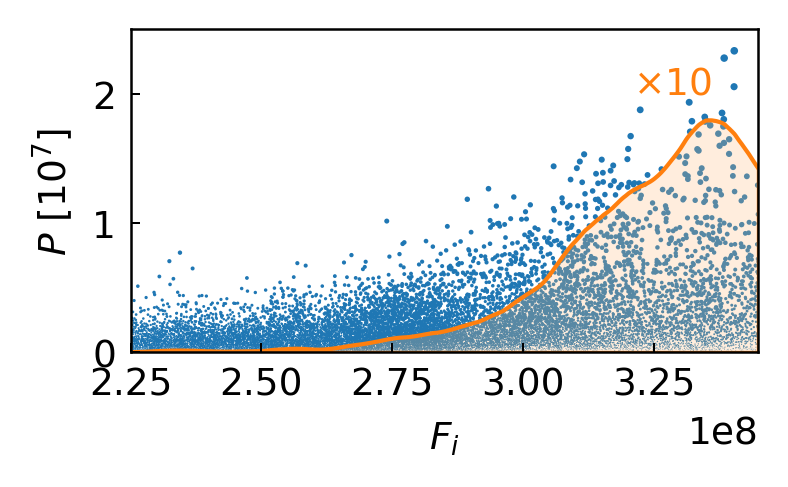

In [67]:
# %% Plot persistence landscapes


def compact_persistence(p):
    """
    This function takes a persistence diagram and returns numpy arrays of births and deaths suitable
    for plotting
    """
    
    # Put all the data into numpy arrays
    births = np.empty(len(p))
    deaths = np.empty(len(p))
    dims = np.empty(len(p), dtype=int)
    for i, (dim, (b, d)) in enumerate(p):
        births[i] = b
        deaths[i] = d
        dims[i] = dim

    # Sort the data by dimension
    dimsort = np.argsort(dims)
    births = births[dimsort]
    deaths = deaths[dimsort]
    dims = dims[dimsort]

    # Find the first instance of dimension 1
    ind = np.searchsorted(dims, 1)
    # Split the data into dimension 0 and dimension 1
    p0 = births[:ind], deaths[:ind]
    p1 = births[ind:], deaths[ind:]

    # Return the data
    return p0, p1


fig = plt.figure(figsize=(2.7, 1.4), dpi=300)

ax = fig.add_subplot(111)
ind = 1

f_range = np.linspace(sample_range[0], sample_range[1], sh_res)

pers = (p1_lower_data[ind][:,1] - p1_lower_data[ind][:,0])/2
fbar = (p1_lower_data[ind][:,1] + p1_lower_data[ind][:,0])/2

fc = np.array(mpl.cm.tab20(3.5/20.0))
fc[3] = 0.25

ax.scatter(fbar, pers*1e-7, color='tab:blue', rasterized=True, alpha=1.0, lw=0, marker='.', s=1.0*(72/300.0)**2 * (pers*1e-5))
ax.fill_between(f_range, s1_trapped_lower[(tinds_blob[ind]-tind_s0)//5,:]*10*1e-7, ec='tab:orange', fc=fc)
#ax.plot(f_range, s1_trapped_lower[(tinds_blob[ind]-tind_s0)//5,:]*10, c='tab:orange')

ax.set_ylabel(R'$P$ [10$^{7}$]')

ax.set_xlim(sample_range[0], sample_range[1])
ax.set_ylim(0, 2.5)

ax.text(x=0.8, y=0.8, s=R'$\times 10$', color='tab:orange', transform=ax.transAxes)
ax.set_xlabel(R'$F_i$')

fig.savefig('./outputs/jpp_figures/blob_persistence.pdf', dpi=300)
fig.savefig('./outputs/jpp_figures/blob_persistence.png', dpi=300)

In [10]:
p0_lower_data[0].shape

(34066, 2)

In [13]:
s1_trapped_lower.shape

(80, 512)

In [65]:
mpl.cm.tab20(3.5/20.0)

(1.0, 0.7333333333333333, 0.47058823529411764, 1.0)